In [ ]:
# In this version, the label is created as follow:
# For each word in the reference, find the time overlap term in hyp.
# If it is the same word, label as 1, otherwise label as 0.
# For each instance of ref word, if none match word and time are found,
# label as "1" and prob as "-1".

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
def compute_overlap(period1, period2):
    '''Compute the overlap percentage between two periods.
    Args:
    period1: list of [stime, etime], dtype=float
    period2: list of [stime, etime], dtype=float
    '''
    if (period2[1] - period1[0]) * (period1[1] - period2[0]) >= 0:
    # Overlap
        stime = max(period1[0], period2[0])
        etime = min(period1[1], period2[1])
        return (etime - stime) / (period1[1] - period1[0])
    else:
        return 0.

def check_duplicates(stored, current):
    '''Check if there are time overlap between the current word and 
    those alreay stored in list. If so only keep the one with largest probability.   
    Args:
    stored: [[begin_frame, duration, probability], [...], ...]
    current: [begin_frame, duration, probability]
    '''         
    overlap_flag = 1            
    update_stored = []
    for i, token in enumerate(stored):
        overlap = compute_overlap([token[0], token[1]], 
                                  [current[0], current[1]])
        if overlap > 0.:
            if token[2] >= current[2]:
                overlap_flag = 0
                update_stored.append(token)
        else:
            update_stored.append(token)
    if overlap_flag == 1:
        update_stored.append(current)
    return update_stored

def read_ctm(fname, chain_model_lats=False):
    dict_utt = {}
    with open(fname, 'r') as fid:
        for line in fid.readlines():
            tokens = line.strip().split()
            uttid = tokens.pop(0)
            tokens.pop(0)
            tokens = [float(i) for i in tokens]
            word = str(int(tokens.pop(2)))
            tokens[1] = tokens[0] + tokens[1]
            tokens[0] *= 100
            tokens[1] *= 100
            if chain_model_lats:
                tokens[0] *= 3
                tokens[1] *= 3
            if uttid in dict_utt.keys():
                if word in dict_utt[uttid].keys():
                    #dict_utt[uttid][word].append(tokens[:3])
                    dict_utt[uttid][word] = check_duplicates(dict_utt[uttid][word], tokens)
                else:
                    dict_utt[uttid][word] = [tokens]
            else:
                dict_utt[uttid] = {}
                dict_utt[uttid][word] = [tokens]
            
    return dict_utt

def read_lattice_post(fname, chain_model_lats=False):
    dict_utt = {}
    with open(fname, 'r') as fid:
        for line in fid.readlines():
            tokens = line.strip().split()
            uttid = tokens.pop(0)
            tokens = [float(i) for i in tokens[:4]]
            word = str(int(tokens[3]))
            tokens[1] = tokens[0] + tokens[1]
            if chain_model_lats:
                tokens[0] *= 3
                tokens[1] *= 3
            if uttid in dict_utt.keys():
                if word in dict_utt[uttid].keys():
                    #dict_utt[uttid][word].append(tokens[:3])
                    dict_utt[uttid][word] = check_duplicates(dict_utt[uttid][word], tokens[:3])
                else:
                    dict_utt[uttid][word] = [tokens[:3]]
            else:
                dict_utt[uttid] = {}
                dict_utt[uttid][word] = [tokens[:3]]
            
    return dict_utt

def detect(ref_words_info, hyp_words_info, uttid, result_fid, overlap_thres=.5):
    '''Search reference word instance in all hypotheses and find matches in word-type and time.
    Both lists contains same words.
    If both match, print ref_word, 1, and hyp_probability;
    if only time matches, print ref_word, 0 and hyp_probability;
    otherwise return nothing.
    Args:
    ref_words_info: (ref_word: [begin_time, duration, probability])
    hyp_words_info: {hyp_word: [[begin_time, duration, probability], ...]}
    Return:
    results: List of results, format like
            e.g, [[ref_word, 1, hyp_prob], [ref_word, 0, hyp_prob], ...]
    '''
    ref_word, ref_info = ref_words_info[0], ref_words_info[1]
    hyp_word, hyp_instances = hyp_words_info[0], hyp_words_info[1]
    ref_period = [ref_info[0], ref_info[1]]
    label = None
    detect_flag = 0
    for hyp in hyp_instances:
        hyp_period = [hyp[0], hyp[1]]
        if compute_overlap(ref_period, hyp_period) >= overlap_thres:
            detect_flag = 1
            if hyp_word == ref_word:
                label = 1
            else:
                label = 0
            print(f'{uttid} {ref_word} {label} {hyp[2]}', file=result_fid)
    return detect_flag

def compute_search_results(dict_ref, dict_hyp, result_fname,
                           word_count_fname, overlap_thres=.5):
    ref_word_counts = {}
    result_fid = open(result_fname, 'w')
    for uttid in dict_ref.keys():
        if uttid not in dict_hyp.keys():
            print(f"Utterance {uttid} does not exist in hypotheses !", 
                  file=sys.stderr)
            continue
        #if '0' in dict_ref[uttid].keys():
        #    dict_ref[uttid].pop('0')
        all_ref_words = dict_ref[uttid]
        all_hyp_words = dict_hyp[uttid]
        search_results = {}
        for refs in all_ref_words.items(): # refs: (word, [[bt1, et1, prob1], [bt2, et2, prob2], ...])
            if not refs[0] in ref_word_counts.keys():
                ref_word_counts[refs[0]] = len(refs[1])
            else:
                ref_word_counts[refs[0]] += len(refs[1])
            for ref_instance in refs[1]:
                ref_item = (refs[0], ref_instance)
                detect_flag = 0
                for hyp in all_hyp_words.items():
                    detect_flag += detect(ref_words_info=ref_item, hyp_words_info=hyp, 
                                         uttid=uttid, result_fid=result_fid,
                                         overlap_thres=overlap_thres)
                if detect_flag == 0:
                    print(f'{uttid} {refs[0]} 1 -1.', file=result_fid)
    result_fid.close()
    word_count_fid = open(word_count_fname, 'w')
    for word, word_count in ref_word_counts.items():
        print(f'Word-id= {word} counts= {word_count}', file=word_count_fid)
    word_count_fid.close()

def read_search_results(result_fname):
    '''Read search results file and store the results for each word in reference.'''
    dict_ref_words_labels = {}
    dict_ref_words_scores = {}
    with open(result_fname, 'r') as fid:
        for line in fid.readlines():
            tokens = line.strip().split()
            uttid = tokens.pop(0)
            ref_word = tokens[0]
            label = int(tokens[1])
            score = float(tokens[2])
            if ref_word in dict_ref_words_labels.keys():
                dict_ref_words_labels[ref_word].append(label)
                dict_ref_words_scores[ref_word].append(score)
            else:
                dict_ref_words_labels[ref_word] = [label]
                dict_ref_words_scores[ref_word] = [score]
    return dict_ref_words_labels, dict_ref_words_scores

def filter_score(labels, scores):
    indexes = np.where(scores >= 0)
    return labels[indexes], scores[indexes]

### Compute det / roc

In [57]:
def compute_precision_recall(scores, labels):
    '''Compute precision, recall, and Area Under Curve (AUC)
    Arguments:
    scores: np.array([], dtype=float)
    labels: np.array([], dtype=float)
    Returns:
    precisions: np.array([], dtype=float)
    recalls: np.array([], dtype=float)
    auc: float
    '''
    
    # Sort the thresolds in descent order
    score_index = np.argsort(scores)[::-1]
    scores = scores[score_index]
    labels = labels[score_index]
    # Remove duplicates scores
    thres_index = np.where(np.diff(scores))[0]
    thres_index = np.r_[thres_index, len(scores) - 1]
    tp = np.cumsum(labels)[thres_index]
    fp = thres_index - tp + 1
    precision = tp / (tp+fp)
    recall = tp / sum(labels)
    #precision = np.r_[1, precision]
    #recall = np.r_[0, recall]
    return precision, recall


def search_and_compute_auc(dict_ref, dict_hyp, result_fname, ref_count_fname):
    compute_search_results(dict_ref=dict_ref, dict_hyp=dict_hyp,
                       result_fname=result_fname,
                       word_count_fname=ref_count_fname)
    dict_ref_words_labels, dict_ref_words_scores = read_search_results(result_fname)
    result_keys = list(dict_ref_words_labels.keys())
    all_labels = []
    all_scores = []
    for k in dict_ref_words_labels.keys():
        all_labels += dict_ref_words_labels[k]
        all_scores += dict_ref_words_scores[k]
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    filt_labs, filt_scores = filter_score(all_labels, all_scores)
    precisions, recalls = compute_precision_recall(labels=filt_labs, scores=filt_scores)
    recalls = recalls * sum(filt_labs) / sum(all_labels)
    auc = np.abs(np.trapz(precisions, recalls))

    return precisions, recalls, auc, filt_scores, filt_labs



### Read files

In [4]:
ref_lats_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/test_data_dir/dev_ali_all_1best_word.post'
hyp_ctm_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/test_data_dir/ctms/dev_ctm.int'
hyp_ctm_cali_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/test_data_dir/ctms/dev_ctm_calibrated.int'
result_fname = './test_data_dir/results_v3/ctms/search_results.txt'
result_fname_cali = './test_data_dir/results_v3/ctms/search_results_cali.txt'
ref_count_fname = './test_data_dir/results_v3/ctms/ref_word_counts.txt'
ref_count_fname_cali = './test_data_dir/results_v3/ctms/ref_word_counts_cali.txt'
dict_ref = read_lattice_post(ref_lats_file)
dict_hyp = read_ctm(hyp_ctm_file, chain_model_lats=True)
dict_hyp_cali = read_ctm(hyp_ctm_cali_file, chain_model_lats=True)
ref_utts = list(dict_ref.keys())
hyp_utts = list(dict_hyp.keys())


### Search

In [59]:
prec, rec, auc, filt_scores, filt_labs = search_and_compute_auc(dict_ref=dict_ref,
                                         dict_hyp=dict_hyp, result_fname=result_fname,
                                         ref_count_fname=ref_count_fname)

prec_cali, rec_cali, auc_cali, filt_scores_cali, filt_labs_cali=search_and_compute_auc(
                                         dict_ref=dict_ref,
                                         dict_hyp=dict_hyp_cali, 
                                         result_fname=result_fname_cali,
                                         ref_count_fname=ref_count_fname_cali)

### Compute AUC

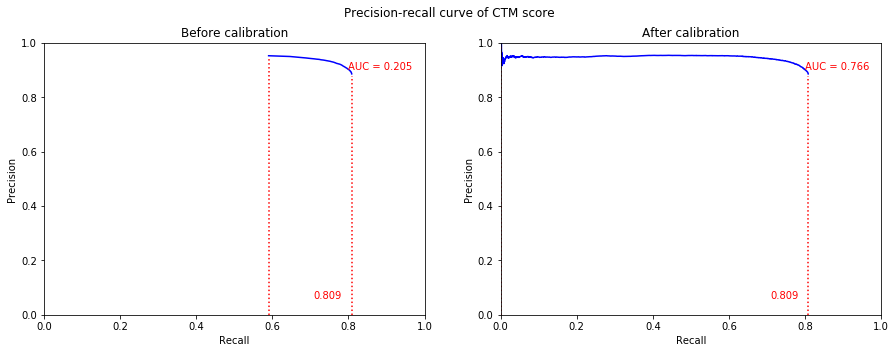

In [60]:
fig, subs = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Precision-recall curve of CTM score')
titles = ['Before calibration', 'After calibration']
recalls = [rec, rec_cali]
precsions = [prec, prec_cali]
aucs = [auc, auc_cali]
for i, s in enumerate(subs):
    s.plot(recalls[i], precsions[i], color='b', linestyle='solid')
    s.set_xlim([0, 1.0])
    s.set_ylim([0, 1.0])
    min_rec = np.arange(0, max(precsions[i]), .01)
    max_rec = np.arange(0, min(precsions[i]), .01)
    s.plot([min(recalls[i])] * len(min_rec), min_rec, linestyle='dotted', color='r')
    s.plot([max(recalls[i])] * len(max_rec), max_rec, linestyle='dotted', color='r')
    s.text(.8, .9, f'AUC = {aucs[i]:.3f}', color='r')
    if min(recalls[i] < 1e-5):
        s.text(min(recalls[i]), .06, f'{min(recalls[i]):.3f}', color='r')
    s.text(max(recalls[i])-.1, .06, f'{max(recalls[i]):.3f}', color='r')
    s.set_ylabel('Precision')
    s.set_xlabel('Recall')
    s.set_title(titles[i])
#plt.savefig('./test_data_dir/results_v3/precision_recall_mine_script.jpg')
plt.show()

### Plot post histogram

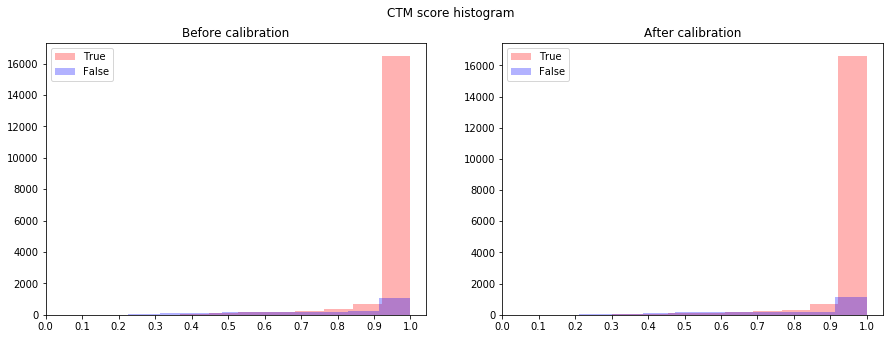

In [55]:
scores = [filt_scores, filt_scores_cali]
labels = [filt_labs, filt_labs_cali]

fig, subs = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('CTM score histogram')
titles = ['Before calibration', 'After calibration']

for i, s in enumerate(subs):
    ref_true_scores = np.array(scores[i])[np.where(np.array(labels[i]) ==1)]
    ref_true_scores = ref_true_scores[np.where(ref_true_scores >= 0)]
    ref_false_scores = np.array(scores[i])[np.where(np.array(labels[i]) ==0)]
    s.hist(ref_true_scores, bins=10, color='r', alpha=.3)
    s.hist(ref_false_scores, bins=10, color='b', alpha=.3)
    s.set_xticks(np.arange(11) * .1)
    s.legend(['True', 'False'])
    s.set_title(titles[i])
plt.show()